# Hawaii Weather Analysis

### Dependencies

In [1]:
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('fivethirtyeight')

In [2]:
# Other dependencies
import datetime as dt
import numpy as np
import pandas as pd

In [3]:
# Python SQL toolkit and object relational mapper (ORM)
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, cast, Integer

### Reflect tables into ORM

In [4]:
# Create SQL engine
engine = create_engine('sqlite:///hawaii.sqlite')
engine

Engine(sqlite:///hawaii.sqlite)

In [5]:
# Reflect tables in the database into a base class
Base = automap_base()
Base.prepare(engine, reflect=True)

# Show all classes that automap found (each class is a table)
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save a reference to each table
M = Base.classes.measurement
S = Base.classes.station

# Create a session
session = Session(engine)
session

In [35]:
# Inspect measurement table
measurement = pd.read_sql('SELECT * FROM measurement', engine)
print(measurement.info())
measurement.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19550 entries, 0 to 19549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       19550 non-null  int64  
 1   station  19550 non-null  object 
 2   date     19550 non-null  object 
 3   prcp     18103 non-null  float64
 4   tobs     19550 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 763.8+ KB
None


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0


In [34]:
# Inspect station table
station = pd.read_sql('SELECT * FROM station', engine)
station

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


### Precipitation in the last 12 months

In [38]:
# Last date in the data
last_date = session.query(func.max(M.date)).first()[0] # 1st row and col of query results
end = dt.datetime.strptime(last_date, '%Y-%m-%d').date() # convert to date type

# Date one year from the last date
start = end - dt.timedelta(days=365)
start

datetime.date(2016, 8, 23)

In [41]:
# Query dates and precipitation scores for the 12-month period
Mprcp = session.query(M.date, M.prcp).filter(M.date >= start).all()
print(len(Mprcp))
Mprcp[:3]

2230


[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08)]

In [67]:
# Extract columns from query results
Mprcp_arr = np.array(Mprcp)
date, prcp = Mprcp_arr[:, 0], Mprcp_arr[:, 1]

# Create a dataframe
Mprcp_df = pd.DataFrame(prcp.astype(float), index=pd.to_datetime(date), columns=['precipitation']).sort_index()
Mprcp_df.head(3)

,precipitation
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79


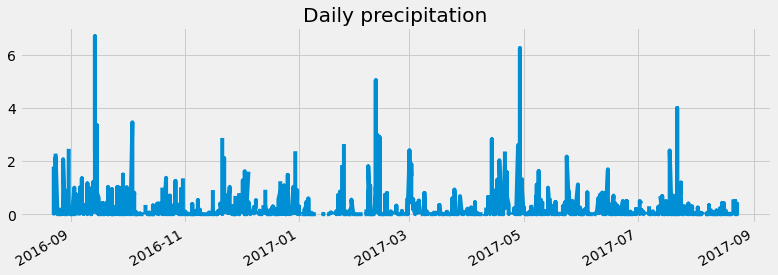

In [70]:
# Plot precipitation
Mprcp_df.plot(figsize=(12, 4), title='Daily precipitation', legend=False)
plt.show()

In [11]:
# Precipitation summary statistics
Mprcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Weather station temperature observations

In [46]:
# Number of stations in the data
session.query(S).count()

9

In [53]:
# Number of measurements from each station
Mcount_bystation = session.query(M.station, func.count(M.station)).group_by(M.station)
Mcount_bystation = Mcount_bystation.order_by(func.count(M.station).desc()).all() # order by descending count
Mcount_bystation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Number of temperature observations from each station
Mtobs_bystation = session.query(M.station, func.count(M.tobs)).filter(M.date >= start)
Mtobs_bystation = Mtobs_bystation.group_by(M.station).order_by(func.count(M.tobs).desc()).all()
Mtobs_bystation

[('USC00519397', 361),
 ('USC00519281', 352),
 ('USC00516128', 349),
 ('USC00513117', 343),
 ('USC00519523', 337),
 ('USC00514830', 305),
 ('USC00517948', 183)]

In [55]:
# Temperature statistics by station
station_temps = session.query(M.station, func.min(M.tobs), func.max(M.tobs), func.avg(M.tobs))
station_temps = station_temps.filter(M.date >= start).group_by(M.station).all()
station_temps

[('USC00513117', 61.0, 82.0, 73.27696793002916),
 ('USC00514830', 63.0, 83.0, 77.16065573770491),
 ('USC00516128', 58.0, 82.0, 72.09169054441261),
 ('USC00517948', 62.0, 87.0, 74.78142076502732),
 ('USC00519281', 59.0, 83.0, 73.10795454545455),
 ('USC00519397', 60.0, 87.0, 75.21052631578948),
 ('USC00519523', 60.0, 85.0, 76.97032640949556)]

In [59]:
# Last 12 months of temperature observations for the most active station (station USC00519397)
s97_temps = session.query(M.date, M.tobs) \
                        .filter((M.station == Mtobs_bystation[0][0]) & (M.date >= start)).all()
s97_temps = np.array(s97_temps)
print(len(s97_temps))
s97_temps[:3]

361


array([['2016-08-23', '81.0'],
       ['2016-08-24', '79.0'],
       ['2016-08-25', '80.0']], dtype='<U10')

[]

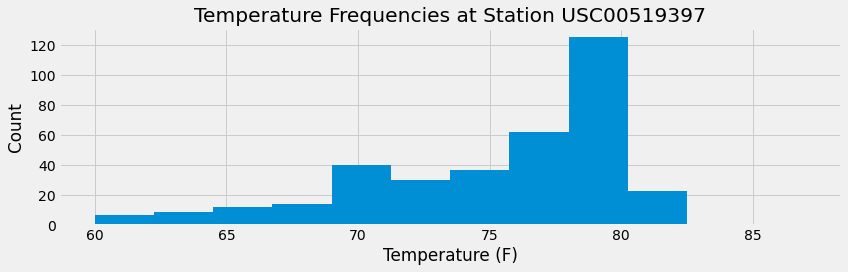

In [71]:
# Histogram of station 97 temperatures
plt.figure(figsize=(12, 4))
plt.hist(s97_temps[:, 1].astype(float), bins=12)

# Formatting
plt.title('Temperature Frequencies at Station ' + Mtobs_bystation[0][0])
plt.ylabel('Count')
plt.xlabel('Temperature (F)')
plt.tight_layout()
plt.plot()

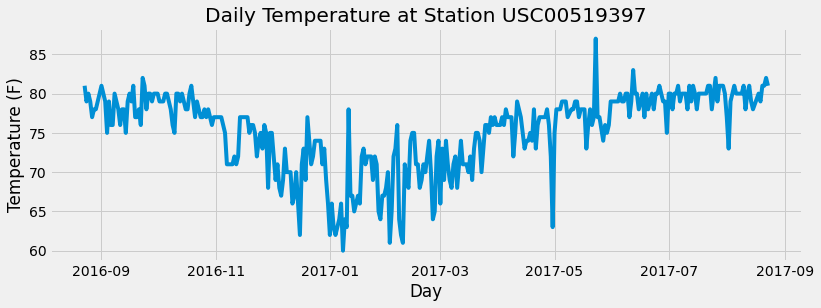

In [73]:
# Lineplot of station 97 temperatures
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(s97_temps[:, 0]), s97_temps[:, 1].astype(float))

# Formatting
plt.title('Daily Temperature at Station ' + Mtobs_bystation[0][0])
plt.ylabel('Temperature (F)')
plt.xlabel('Day')
plt.show()

In [19]:
def calc_temps(start_date=start, end_date=end):
    
    ''' 
    Calculate the minimum, average, and maximum temperatures for each station 
    for the specified date range.
    
    Args:
        [1] start_date (str) - in the format "%Y-%M-%D"
        [2] end_date (str) - in the format "%Y-%M-%D"
        
    Returns:
        (Pandas dataframe) minimum, average, and maximum temperature for each
        station in the date range.
    '''
    
    temps = session.query(M.station, func.min(M.tobs), func.max(M.tobs), func.avg(M.tobs))
    temps = temps.filter((M.date >= start_date) & (M.date <= end_date)).group_by(M.station).all()
    return pd.DataFrame(temps, columns=['station', 'min_temp', 'avg_temp', 'max_temp'])


# Test function
calc_temps('2016-01-01', '2016-12-31')

,station,min_temp,avg_temp,max_temp
0,USC00513117,63.0,80.0,73.587432
1,USC00514830,63.0,83.0,76.468553
2,USC00516128,60.0,81.0,71.099707
3,USC00517948,62.0,82.0,75.028846
4,USC00519281,56.0,82.0,73.101093
5,USC00519397,61.0,82.0,74.497268
6,USC00519523,59.0,84.0,75.805233


### Monthly weather analysis - Pandas

In [20]:
# Use Pandas to extract measurement table
measurement = pd.read_sql('SELECT * FROM measurement', engine)
measurement.head(3)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0


In [21]:
# Extract month from date
measurement['month'] = measurement['date'].str.split('-', expand=True)[1].astype(int)
measurement.head(3)

,id,station,date,prcp,tobs,month
0,1,USC00519397,2010-01-01,0.08,65.0,1
1,2,USC00519397,2010-01-02,0.00,63.0,1
2,3,USC00519397,2010-01-03,0.00,74.0,1


In [25]:
# Temperature and precipitation statistics by month
columns = [(meas, stat) for meas in ['tobs', 'prcp'] for stat in ['mean', 'std', 'min', 'max']]
measurement.groupby('month').describe().round(2)[columns]

tobs                    prcp                  
        mean   std   min   max  mean   std  min    max
month                                                 
1      68.73  4.37  54.0  81.0  0.13  0.48  0.0   8.81
2      69.44  3.98  56.0  83.0  0.14  0.40  0.0   5.04
3      70.06  3.85  56.0  82.0  0.20  0.57  0.0   6.38
4      72.36  3.63  53.0  84.0  0.15  0.42  0.0   6.25
5      73.68  3.36  63.0  87.0  0.15  0.37  0.0   4.07
6      74.94  3.26  64.0  85.0  0.14  0.34  0.0   4.43
7      76.08  3.36  61.0  87.0  0.17  0.63  0.0  11.53
8      76.41  3.45  65.0  87.0  0.15  0.41  0.0   4.81
9      76.16  3.54  64.0  87.0  0.16  0.44  0.0   6.83
10     75.39  3.55  64.0  86.0  0.16  0.44  0.0   4.47
11     73.25  3.62  61.0  83.0  0.18  0.51  0.0   8.06
12     71.04  3.75  56.0  83.0  0.22  0.54  0.0   6.42

### Monthly weather analysis - ORM

In [30]:
# Subquery to extract month, temperature (tobs), and precipitation (prcp)
sub = session.query(func.extract('month', M.date).label('month'), M.tobs, M.prcp).subquery()

# Create a list for the statistics to calculate: min_tobs, avg_tobs, max_tobs, min_prcp, avg_prcp, max_prcp
SELECT = [func.round(F(stat), 2) for stat in [sub.c.tobs, sub.c.prcp] 
                                 for F in [func.min, func.avg, func.max]]
SELECT.insert(0, sub.c.month) # insert month as the 1st col

# Temperature and precipitation statistics by month
results = session.query(*SELECT).group_by(SELECT[0]).all()
results_df = pd.DataFrame(results, 
                          columns=[None, 'min_temp', 'avg_temp', 'max_temp', 'min_prcp', 'avg_prcp', 'max_prcp'])
results_df.set_index(None, inplace=True)
results_df

,min_temp,avg_temp,max_temp,min_prcp,avg_prcp,max_prcp
1,54.0,68.73,81.0,0.0,0.13,8.81
2,56.0,69.44,83.0,0.0,0.14,5.04
3,56.0,70.06,82.0,0.0,0.20,6.38
4,53.0,72.36,84.0,0.0,0.15,6.25
5,63.0,73.68,87.0,0.0,0.15,4.07
6,64.0,74.94,85.0,0.0,0.14,4.43
7,61.0,76.08,87.0,0.0,0.17,11.53
8,65.0,76.41,87.0,0.0,0.15,4.81
9,64.0,76.16,87.0,0.0,0.16,6.83
10,64.0,75.39,86.0,0.0,0.16,4.47
